In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

import holidays as hld
import json
import requests as rq

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

C:\Users\Asus\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [240]:
orders_pred = pd.read_csv('final_res.csv')
orders_strt = pd.read_csv('orders.csv')
delays_strt = pd.read_csv('partners_delays.csv')

In [241]:
orders17 = orders_strt[orders_strt['delivery_area_id']==17]
delays17 = delays_strt[delays_strt['delivery_area_id']==17]

In [242]:
orders17 = orders17.drop('delivery_area_id', axis=1)
delays17 = delays17.drop('delivery_area_id', axis=1)

In [243]:
orders17['date'] = pd.to_datetime(orders17['date'])
delays17['dttm'] = pd.to_datetime(delays17['dttm'])

In [244]:
orders17 = orders17.set_index('date')
delays17 = delays17.set_index('dttm')

In [245]:
orders17 = orders17.asfreq('H')
delays17 = delays17.asfreq('H')


In [246]:
orders17 = orders17.interpolate()
delays17 = delays17.interpolate()


In [247]:
con = pd.merge(delays17, orders17, left_index=True, right_index=True, how='left')
con = con.dropna()

In [248]:
con.head()

,partners_cnt,delay_rate,orders_cnt
dttm,,,
2021-04-01 08:00:00,2.0,0.0,1.0
2021-04-01 09:00:00,2.0,0.0,2.0
2021-04-01 10:00:00,3.0,0.0,8.0
2021-04-01 11:00:00,1.0,0.0,2.0
2021-04-01 12:00:00,2.0,0.0,5.0


In [249]:
con['perc'] = con['orders_cnt']/con['partners_cnt']

In [250]:
con = con.reset_index()
con

,dttm,partners_cnt,delay_rate,orders_cnt,perc
0,2021-04-01 08:00:00,2.0,0.000000,1.0,0.500000
1,2021-04-01 09:00:00,2.0,0.000000,2.0,1.000000
2,2021-04-01 10:00:00,3.0,0.000000,8.0,2.666667
3,2021-04-01 11:00:00,1.0,0.000000,2.0,2.000000
4,2021-04-01 12:00:00,2.0,0.000000,5.0,2.500000
...,...,...,...,...,...
5841,2021-11-30 17:00:00,11.0,0.107143,28.0,2.545455
5842,2021-11-30 18:00:00,14.0,0.142857,35.0,2.500000
5843,2021-11-30 19:00:00,15.0,0.128205,39.0,2.600000
5844,2021-11-30 20:00:00,15.0,0.170732,41.0,2.733333


In [251]:
def create_features(delays):

    delays['dttm'] = pd.to_datetime(delays['dttm'])
    delays_dates = delays['dttm']
    delays['day'] = delays_dates.apply(lambda x: x.day)
    delays['hour'] = delays_dates.apply(lambda x: x.hour)
    delays['weekday'] = delays_dates.apply(lambda x: x.weekday())
    delays['day_of_year'] = delays_dates.apply(lambda x: x.dayofyear)
    day_freq_delays = delays['day'].value_counts(normalize=True).to_dict()
    delays['day_freq'] = delays['day'].map(day_freq_delays)
    weekday_freq_delays = delays['weekday'].value_counts(normalize=True).to_dict()
    delays['weekday_freq'] = delays['weekday'].map(weekday_freq_delays)
    delays_dates = delays['dttm']
    holidays = [date[0] for date in hld.Russia(years=2021).items()]

    delays_dates = delays_dates.to_frame().sort_values(by='dttm')

    df_holidays = pd.DataFrame({'holidays': holidays})
    df_holidays['holidays'] = pd.to_datetime(df_holidays['holidays'])

    delays_dates = pd.merge_asof(delays_dates, df_holidays, left_on='dttm', right_on='holidays', direction='forward')
    delays_dates = pd.merge_asof(delays_dates, df_holidays, left_on='dttm', right_on='holidays')

    delays_dates['days_until_holiday'] = delays_dates.pop('holidays_x').sub(delays_dates['dttm']).dt.days
    delays_dates['days_since_holiday'] = delays_dates['dttm'].sub(delays_dates.pop('holidays_y')).dt.days

    delays_dates =  delays_dates.drop_duplicates()
    delays = pd.merge(delays, delays_dates, how='left', on='dttm')
    delays_dates = delays['dttm']

    url = 'https://raw.githubusercontent.com/d10xa/holidays-calendar/master/json/consultant2021.json'
    response = rq.get(url)
    non_working = json.loads(response.text)

    for days in non_working:
        non_working[days] = pd.to_datetime(non_working.get(days)).date

    delays['is_holiday'] = delays_dates.apply(lambda x: x.date() in non_working['holidays']) * 1
    delays['is_weekend'] = ((delays['weekday']==5) | (delays['weekday']==6)) * 1
    delays_dates = delays_dates.to_frame().sort_values(by='dttm')

    sorted_nonworking = np.sort(np.concatenate((non_working['holidays'], non_working['nowork'])))

    df_non_working = pd.DataFrame({'non_working': sorted_nonworking})
    df_non_working['non_working'] = pd.to_datetime(df_non_working['non_working'])

    delays_dates = pd.merge_asof(delays_dates, df_non_working, left_on='dttm', right_on='non_working', direction='forward')
    delays_dates = pd.merge_asof(delays_dates, df_non_working, left_on='dttm', right_on='non_working')

    delays_dates['days_until_nonworking'] = delays_dates.pop('non_working_x').sub(delays_dates['dttm']).dt.days
    delays_dates['days_since_nonworking'] = delays_dates['dttm'].sub(delays_dates.pop('non_working_y')).dt.days

    delays_dates =  delays_dates.drop_duplicates()

    delays = pd.merge(delays, delays_dates, how='left', on='dttm')



    return delays

In [252]:
con

,dttm,partners_cnt,delay_rate,orders_cnt,perc
0,2021-04-01 08:00:00,2.0,0.000000,1.0,0.500000
1,2021-04-01 09:00:00,2.0,0.000000,2.0,1.000000
2,2021-04-01 10:00:00,3.0,0.000000,8.0,2.666667
3,2021-04-01 11:00:00,1.0,0.000000,2.0,2.000000
4,2021-04-01 12:00:00,2.0,0.000000,5.0,2.500000
...,...,...,...,...,...
5841,2021-11-30 17:00:00,11.0,0.107143,28.0,2.545455
5842,2021-11-30 18:00:00,14.0,0.142857,35.0,2.500000
5843,2021-11-30 19:00:00,15.0,0.128205,39.0,2.600000
5844,2021-11-30 20:00:00,15.0,0.170732,41.0,2.733333


In [253]:
con = create_features(con)

In [254]:
con = con.set_index('dttm')

In [255]:
FEATURES = ['partners_cnt', 'orders_cnt', 'perc', 'day', 'hour',
       'weekday', 'day_of_year', 'day_freq', 'weekday_freq',
       'days_until_holiday', 'days_since_holiday', 'is_holiday', 'is_weekend',
       'days_until_nonworking', 'days_since_nonworking']
TARGET = 'delay_rate'

In [256]:
tscv = TimeSeriesSplit(n_splits=5, test_size=int(len(con)*.05), gap=24)

In [257]:
preds = []
scores = []

for train_index, test_index in tscv.split(con):

    train = con.iloc[train_index]
    test = con.iloc[test_index]

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                          n_estimators=1000,
                          early_stopping_rounds=50,
                          objective='reg:linear',
                          max_depth=5,
                          learning_rate=0.01)
    reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[23:45:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[23:45:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:0.45597	validation_1-rmse:0.44308


C:\Users\Asus\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:0.18359	validation_1-rmse:0.17496
[200]	validation_0-rmse:0.09793	validation_1-rmse:0.09580
[300]	validation_0-rmse:0.07766	validation_1-rmse:0.07510
[400]	validation_0-rmse:0.07313	validation_1-rmse:0.07001
[500]	validation_0-rmse:0.07139	validation_1-rmse:0.06913
[600]	validation_0-rmse:0.07028	validation_1-rmse:0.06922
[700]	validation_0-rmse:0.06917	validation_1-rmse:0.06931
[800]	validation_0-rmse:0.06817	validation_1-rmse:0.06944
[900]	validation_0-rmse:0.06726	validation_1-rmse:0.06979
[999]	validation_0-rmse:0.06644	validation_1-rmse:0.07019
[23:45:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[23:45:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bind

C:\Users\Asus\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:0.18281	validation_1-rmse:0.17425
[200]	validation_0-rmse:0.09696	validation_1-rmse:0.08415
[300]	validation_0-rmse:0.07663	validation_1-rmse:0.06000
[400]	validation_0-rmse:0.07209	validation_1-rmse:0.05486
[500]	validation_0-rmse:0.07022	validation_1-rmse:0.05415
[600]	validation_0-rmse:0.06892	validation_1-rmse:0.05433
[700]	validation_0-rmse:0.06780	validation_1-rmse:0.05418
[800]	validation_0-rmse:0.06651	validation_1-rmse:0.05430
[900]	validation_0-rmse:0.06536	validation_1-rmse:0.05503
[999]	validation_0-rmse:0.06469	validation_1-rmse:0.05581
[23:45:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[23:45:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bind

C:\Users\Asus\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:0.18200	validation_1-rmse:0.17211
[200]	validation_0-rmse:0.09625	validation_1-rmse:0.08645
[300]	validation_0-rmse:0.07636	validation_1-rmse:0.06565
[400]	validation_0-rmse:0.07186	validation_1-rmse:0.06180
[500]	validation_0-rmse:0.07020	validation_1-rmse:0.06175
[600]	validation_0-rmse:0.06914	validation_1-rmse:0.06236
[700]	validation_0-rmse:0.06795	validation_1-rmse:0.06353
[800]	validation_0-rmse:0.06688	validation_1-rmse:0.06466
[900]	validation_0-rmse:0.06584	validation_1-rmse:0.06557
[999]	validation_0-rmse:0.06499	validation_1-rmse:0.06639
[23:45:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[23:45:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bind

C:\Users\Asus\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:0.18128	validation_1-rmse:0.17562
[200]	validation_0-rmse:0.09563	validation_1-rmse:0.09590
[300]	validation_0-rmse:0.07537	validation_1-rmse:0.08142
[400]	validation_0-rmse:0.07098	validation_1-rmse:0.07903
[500]	validation_0-rmse:0.06947	validation_1-rmse:0.07875
[600]	validation_0-rmse:0.06829	validation_1-rmse:0.07892
[700]	validation_0-rmse:0.06717	validation_1-rmse:0.07909
[800]	validation_0-rmse:0.06631	validation_1-rmse:0.07920
[900]	validation_0-rmse:0.06556	validation_1-rmse:0.07918
[999]	validation_0-rmse:0.06458	validation_1-rmse:0.07915
[23:45:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[23:45:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bind

C:\Users\Asus\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:0.18077	validation_1-rmse:0.17292
[200]	validation_0-rmse:0.09553	validation_1-rmse:0.08233
[300]	validation_0-rmse:0.07537	validation_1-rmse:0.05734
[400]	validation_0-rmse:0.07085	validation_1-rmse:0.05264
[500]	validation_0-rmse:0.06918	validation_1-rmse:0.05249
[600]	validation_0-rmse:0.06813	validation_1-rmse:0.05368
[700]	validation_0-rmse:0.06692	validation_1-rmse:0.05384
[800]	validation_0-rmse:0.06610	validation_1-rmse:0.05422
[900]	validation_0-rmse:0.06518	validation_1-rmse:0.05443
[999]	validation_0-rmse:0.06441	validation_1-rmse:0.05488


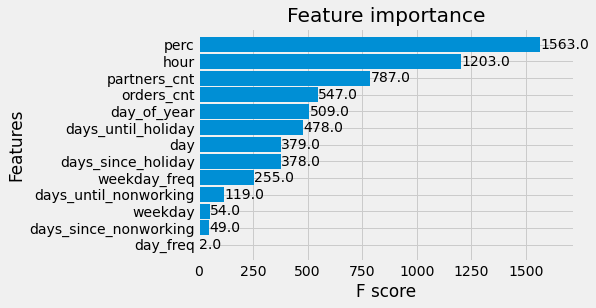

In [93]:
_ = xgb.plot_importance(reg, height=0.9)

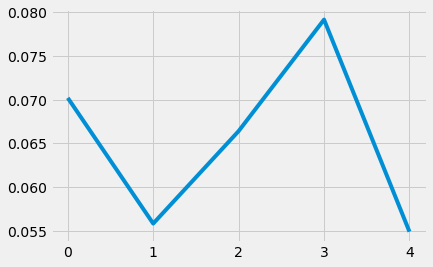

In [258]:
plt.plot(scores)

In [259]:
pd.concat([X_test.reset_index(), pd.DataFrame(preds[4], columns=['delay_rate'])], axis=1)

,dttm,partners_cnt,orders_cnt,perc,day,hour,weekday,day_of_year,day_freq,weekday_freq,days_until_holiday,days_since_holiday,is_holiday,is_weekend,days_until_nonworking,days_since_nonworking,delay_rate
0,2021-11-18 18:00:00,10.0,27.0,2.700000,18,18,3,322,0.032843,0.142320,42,14,0,0,1,4,0.138825
1,2021-11-18 19:00:00,11.0,29.0,2.636364,18,19,3,322,0.032843,0.142320,42,14,0,0,1,4,0.152813
2,2021-11-18 20:00:00,8.0,22.0,2.750000,18,20,3,322,0.032843,0.142320,42,14,0,0,1,4,0.096944
3,2021-11-18 21:00:00,5.0,12.0,2.400000,18,21,3,322,0.032843,0.142320,42,14,0,0,1,4,0.159145
4,2021-11-18 22:00:00,1.0,11.0,11.000000,18,22,3,322,0.032843,0.142320,42,14,0,0,1,4,-0.005238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,2021-11-30 17:00:00,11.0,28.0,2.545455,30,17,1,334,0.032501,0.143346,30,26,0,0,3,2,0.111656
288,2021-11-30 18:00:00,14.0,35.0,2.500000,30,18,1,334,0.032501,0.143346,30,26,0,0,3,2,0.127171
289,2021-11-30 19:00:00,15.0,39.0,2.600000,30,19,1,334,0.032501,0.143346,30,26,0,0,3,2,0.144851
290,2021-11-30 20:00:00,15.0,41.0,2.733333,30,20,1,334,0.032501,0.143346,30,26,0,0,3,2,0.127734


In [260]:
con_proxy = con.copy()
con_lst = []
for i in range(len(con)):
    proxy = pd.DataFrame([con_proxy.iloc[i]]*20)
    proxy["partners_cnt"] = range(1, 21)
    con_lst.append(proxy)

In [261]:
to_test = pd.concat(con_lst)
to_test['perc'] = to_test['orders_cnt']/to_test['partners_cnt']
to_test = to_test.drop('delay_rate', axis=1)
to_test

,partners_cnt,orders_cnt,perc,day,hour,weekday,day_of_year,day_freq,weekday_freq,days_until_holiday,days_since_holiday,is_holiday,is_weekend,days_until_nonworking,days_since_nonworking
2021-04-01 08:00:00,1,1.0,1.000000,1.0,8.0,3.0,91.0,0.031475,0.142320,29.0,24.0,0.0,0.0,1.0,4.0
2021-04-01 08:00:00,2,1.0,0.500000,1.0,8.0,3.0,91.0,0.031475,0.142320,29.0,24.0,0.0,0.0,1.0,4.0
2021-04-01 08:00:00,3,1.0,0.333333,1.0,8.0,3.0,91.0,0.031475,0.142320,29.0,24.0,0.0,0.0,1.0,4.0
2021-04-01 08:00:00,4,1.0,0.250000,1.0,8.0,3.0,91.0,0.031475,0.142320,29.0,24.0,0.0,0.0,1.0,4.0
2021-04-01 08:00:00,5,1.0,0.200000,1.0,8.0,3.0,91.0,0.031475,0.142320,29.0,24.0,0.0,0.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30 21:00:00,16,10.0,0.625000,30.0,21.0,1.0,334.0,0.032501,0.143346,30.0,26.0,0.0,0.0,3.0,2.0
2021-11-30 21:00:00,17,10.0,0.588235,30.0,21.0,1.0,334.0,0.032501,0.143346,30.0,26.0,0.0,0.0,3.0,2.0
2021-11-30 21:00:00,18,10.0,0.555556,30.0,21.0,1.0,334.0,0.032501,0.143346,30.0,26.0,0.0,0.0,3.0,2.0
2021-11-30 21:00:00,19,10.0,0.526316,30.0,21.0,1.0,334.0,0.032501,0.143346,30.0,26.0,0.0,0.0,3.0,2.0


In [262]:
test_pred = reg.predict(to_test)


In [274]:
con_cls_proxy = pd.concat([to_test.reset_index(), pd.DataFrame(test_pred, columns=['delay_rate'])], axis=1).iloc[:20]
con_cls_proxy

,index,partners_cnt,orders_cnt,perc,day,hour,weekday,day_of_year,day_freq,weekday_freq,days_until_holiday,days_since_holiday,is_holiday,is_weekend,days_until_nonworking,days_since_nonworking,delay_rate
0,2021-04-01 08:00:00,1,1.0,1.000000,1.0,8.0,3.0,91.0,0.031475,0.14232,29.0,24.0,0.0,0.0,1.0,4.0,0.007689
1,2021-04-01 08:00:00,2,1.0,0.500000,1.0,8.0,3.0,91.0,0.031475,0.14232,29.0,24.0,0.0,0.0,1.0,4.0,0.004304
2,2021-04-01 08:00:00,3,1.0,0.333333,1.0,8.0,3.0,91.0,0.031475,0.14232,29.0,24.0,0.0,0.0,1.0,4.0,-0.011988
3,2021-04-01 08:00:00,4,1.0,0.250000,1.0,8.0,3.0,91.0,0.031475,0.14232,29.0,24.0,0.0,0.0,1.0,4.0,-0.008363
4,2021-04-01 08:00:00,5,1.0,0.200000,1.0,8.0,3.0,91.0,0.031475,0.14232,29.0,24.0,0.0,0.0,1.0,4.0,-0.010124
5,2021-04-01 08:00:00,6,1.0,0.166667,1.0,8.0,3.0,91.0,0.031475,0.14232,29.0,24.0,0.0,0.0,1.0,4.0,0.112069
6,2021-04-01 08:00:00,7,1.0,0.142857,1.0,8.0,3.0,91.0,0.031475,0.14232,29.0,24.0,0.0,0.0,1.0,4.0,0.008678
7,2021-04-01 08:00:00,8,1.0,0.125000,1.0,8.0,3.0,91.0,0.031475,0.14232,29.0,24.0,0.0,0.0,1.0,4.0,0.010982
8,2021-04-01 08:00:00,9,1.0,0.111111,1.0,8.0,3.0,91.0,0.031475,0.14232,29.0,24.0,0.0,0.0,1.0,4.0,0.010982
9,2021-04-01 08:00:00,10,1.0,0.100000,1.0,8.0,3.0,91.0,0.031475,0.14232,29.0,24.0,0.0,0.0,1.0,4.0,0.010982


In [264]:
con_cls_proxy['delay_rate'] = (con_cls_proxy['delay_rate']<0.05)*1
con_cls_proxy

,index,partners_cnt,orders_cnt,perc,day,hour,weekday,day_of_year,day_freq,weekday_freq,days_until_holiday,days_since_holiday,is_holiday,is_weekend,days_until_nonworking,days_since_nonworking,delay_rate
0,2021-04-01 08:00:00,1,1.0,1.000000,1.0,8.0,3.0,91.0,0.031475,0.142320,29.0,24.0,0.0,0.0,1.0,4.0,1
1,2021-04-01 08:00:00,2,1.0,0.500000,1.0,8.0,3.0,91.0,0.031475,0.142320,29.0,24.0,0.0,0.0,1.0,4.0,1
2,2021-04-01 08:00:00,3,1.0,0.333333,1.0,8.0,3.0,91.0,0.031475,0.142320,29.0,24.0,0.0,0.0,1.0,4.0,1
3,2021-04-01 08:00:00,4,1.0,0.250000,1.0,8.0,3.0,91.0,0.031475,0.142320,29.0,24.0,0.0,0.0,1.0,4.0,1
4,2021-04-01 08:00:00,5,1.0,0.200000,1.0,8.0,3.0,91.0,0.031475,0.142320,29.0,24.0,0.0,0.0,1.0,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116915,2021-11-30 21:00:00,16,10.0,0.625000,30.0,21.0,1.0,334.0,0.032501,0.143346,30.0,26.0,0.0,0.0,3.0,2.0,0
116916,2021-11-30 21:00:00,17,10.0,0.588235,30.0,21.0,1.0,334.0,0.032501,0.143346,30.0,26.0,0.0,0.0,3.0,2.0,0
116917,2021-11-30 21:00:00,18,10.0,0.555556,30.0,21.0,1.0,334.0,0.032501,0.143346,30.0,26.0,0.0,0.0,3.0,2.0,0
116918,2021-11-30 21:00:00,19,10.0,0.526316,30.0,21.0,1.0,334.0,0.032501,0.143346,30.0,26.0,0.0,0.0,3.0,2.0,0


In [271]:
X_train, X_test, y_train, y_test = train_test_split(con_cls_proxy[FEATURES], con_cls_proxy[TARGET], test_size=0.05, random_state=1)

In [272]:
model = XGBClassifier(base_score=0.5, booster='gbtree',    
                      n_estimators=1000,
                      early_stopping_rounds=50,
                      objective='reg:linear',
                      max_depth=5,
                      learning_rate=0.01,
                      evalmetric='logloss',
                      use_label_encoder=False)

In [273]:
model.fit(X_train, y_train)

C:\Users\Asus\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:50:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[23:50:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "evalmetric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
              enable_categorical=False, evalmetric='logloss', gamma=0,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=8, num_parallel_tree=1,
              objective='reg:linear', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False, ...)

In [275]:
y_pred = model.predict(X_test)

In [276]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9375641464249059

In [277]:
test_cls_pred = model.predict(to_test)
test_cls_pred

array([1, 1, 1, ..., 0, 0, 0])

In [278]:
frame = pd.concat([to_test.reset_index(), pd.DataFrame(test_pred, columns=['delay_rate']), pd.DataFrame(test_cls_pred, columns=['delay'])], axis=1)

In [279]:
frame['delay'] = frame['delay'].map({0:1, 1:0})

In [280]:
frame

,index,partners_cnt,orders_cnt,perc,day,hour,weekday,day_of_year,day_freq,weekday_freq,days_until_holiday,days_since_holiday,is_holiday,is_weekend,days_until_nonworking,days_since_nonworking,delay_rate,delay
0,2021-04-01 08:00:00,1,1.0,1.000000,1.0,8.0,3.0,91.0,0.031475,0.142320,29.0,24.0,0.0,0.0,1.0,4.0,0.007689,0
1,2021-04-01 08:00:00,2,1.0,0.500000,1.0,8.0,3.0,91.0,0.031475,0.142320,29.0,24.0,0.0,0.0,1.0,4.0,0.004304,0
2,2021-04-01 08:00:00,3,1.0,0.333333,1.0,8.0,3.0,91.0,0.031475,0.142320,29.0,24.0,0.0,0.0,1.0,4.0,-0.011988,0
3,2021-04-01 08:00:00,4,1.0,0.250000,1.0,8.0,3.0,91.0,0.031475,0.142320,29.0,24.0,0.0,0.0,1.0,4.0,-0.008363,0
4,2021-04-01 08:00:00,5,1.0,0.200000,1.0,8.0,3.0,91.0,0.031475,0.142320,29.0,24.0,0.0,0.0,1.0,4.0,-0.010124,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116915,2021-11-30 21:00:00,16,10.0,0.625000,30.0,21.0,1.0,334.0,0.032501,0.143346,30.0,26.0,0.0,0.0,3.0,2.0,0.091148,1
116916,2021-11-30 21:00:00,17,10.0,0.588235,30.0,21.0,1.0,334.0,0.032501,0.143346,30.0,26.0,0.0,0.0,3.0,2.0,0.092756,1
116917,2021-11-30 21:00:00,18,10.0,0.555556,30.0,21.0,1.0,334.0,0.032501,0.143346,30.0,26.0,0.0,0.0,3.0,2.0,0.116266,1
116918,2021-11-30 21:00:00,19,10.0,0.526316,30.0,21.0,1.0,334.0,0.032501,0.143346,30.0,26.0,0.0,0.0,3.0,2.0,0.128981,1


In [281]:
frame['delay_rate'] = (frame['delay_rate']>0.05)*1
frame

,index,partners_cnt,orders_cnt,perc,day,hour,weekday,day_of_year,day_freq,weekday_freq,days_until_holiday,days_since_holiday,is_holiday,is_weekend,days_until_nonworking,days_since_nonworking,delay_rate,delay
0,2021-04-01 08:00:00,1,1.0,1.000000,1.0,8.0,3.0,91.0,0.031475,0.142320,29.0,24.0,0.0,0.0,1.0,4.0,0,0
1,2021-04-01 08:00:00,2,1.0,0.500000,1.0,8.0,3.0,91.0,0.031475,0.142320,29.0,24.0,0.0,0.0,1.0,4.0,0,0
2,2021-04-01 08:00:00,3,1.0,0.333333,1.0,8.0,3.0,91.0,0.031475,0.142320,29.0,24.0,0.0,0.0,1.0,4.0,0,0
3,2021-04-01 08:00:00,4,1.0,0.250000,1.0,8.0,3.0,91.0,0.031475,0.142320,29.0,24.0,0.0,0.0,1.0,4.0,0,0
4,2021-04-01 08:00:00,5,1.0,0.200000,1.0,8.0,3.0,91.0,0.031475,0.142320,29.0,24.0,0.0,0.0,1.0,4.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116915,2021-11-30 21:00:00,16,10.0,0.625000,30.0,21.0,1.0,334.0,0.032501,0.143346,30.0,26.0,0.0,0.0,3.0,2.0,1,1
116916,2021-11-30 21:00:00,17,10.0,0.588235,30.0,21.0,1.0,334.0,0.032501,0.143346,30.0,26.0,0.0,0.0,3.0,2.0,1,1
116917,2021-11-30 21:00:00,18,10.0,0.555556,30.0,21.0,1.0,334.0,0.032501,0.143346,30.0,26.0,0.0,0.0,3.0,2.0,1,1
116918,2021-11-30 21:00:00,19,10.0,0.526316,30.0,21.0,1.0,334.0,0.032501,0.143346,30.0,26.0,0.0,0.0,3.0,2.0,1,1


In [282]:
frame['score'] = frame['delay'] + frame['delay_rate']
frame

,index,partners_cnt,orders_cnt,perc,day,hour,weekday,day_of_year,day_freq,weekday_freq,days_until_holiday,days_since_holiday,is_holiday,is_weekend,days_until_nonworking,days_since_nonworking,delay_rate,delay,score
0,2021-04-01 08:00:00,1,1.0,1.000000,1.0,8.0,3.0,91.0,0.031475,0.142320,29.0,24.0,0.0,0.0,1.0,4.0,0,0,0
1,2021-04-01 08:00:00,2,1.0,0.500000,1.0,8.0,3.0,91.0,0.031475,0.142320,29.0,24.0,0.0,0.0,1.0,4.0,0,0,0
2,2021-04-01 08:00:00,3,1.0,0.333333,1.0,8.0,3.0,91.0,0.031475,0.142320,29.0,24.0,0.0,0.0,1.0,4.0,0,0,0
3,2021-04-01 08:00:00,4,1.0,0.250000,1.0,8.0,3.0,91.0,0.031475,0.142320,29.0,24.0,0.0,0.0,1.0,4.0,0,0,0
4,2021-04-01 08:00:00,5,1.0,0.200000,1.0,8.0,3.0,91.0,0.031475,0.142320,29.0,24.0,0.0,0.0,1.0,4.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116915,2021-11-30 21:00:00,16,10.0,0.625000,30.0,21.0,1.0,334.0,0.032501,0.143346,30.0,26.0,0.0,0.0,3.0,2.0,1,1,2
116916,2021-11-30 21:00:00,17,10.0,0.588235,30.0,21.0,1.0,334.0,0.032501,0.143346,30.0,26.0,0.0,0.0,3.0,2.0,1,1,2
116917,2021-11-30 21:00:00,18,10.0,0.555556,30.0,21.0,1.0,334.0,0.032501,0.143346,30.0,26.0,0.0,0.0,3.0,2.0,1,1,2
116918,2021-11-30 21:00:00,19,10.0,0.526316,30.0,21.0,1.0,334.0,0.032501,0.143346,30.0,26.0,0.0,0.0,3.0,2.0,1,1,2


In [287]:
frame.iloc[40:60]

,index,partners_cnt,orders_cnt,perc,day,hour,weekday,day_of_year,day_freq,weekday_freq,days_until_holiday,days_since_holiday,is_holiday,is_weekend,days_until_nonworking,days_since_nonworking,delay_rate,delay,score
40,2021-04-01 10:00:00,1,8.0,8.000000,1.0,10.0,3.0,91.0,0.031475,0.14232,29.0,24.0,0.0,0.0,1.0,4.0,0,1,1
41,2021-04-01 10:00:00,2,8.0,4.000000,1.0,10.0,3.0,91.0,0.031475,0.14232,29.0,24.0,0.0,0.0,1.0,4.0,1,1,2
42,2021-04-01 10:00:00,3,8.0,2.666667,1.0,10.0,3.0,91.0,0.031475,0.14232,29.0,24.0,0.0,0.0,1.0,4.0,0,1,1
43,2021-04-01 10:00:00,4,8.0,2.000000,1.0,10.0,3.0,91.0,0.031475,0.14232,29.0,24.0,0.0,0.0,1.0,4.0,1,1,2
44,2021-04-01 10:00:00,5,8.0,1.600000,1.0,10.0,3.0,91.0,0.031475,0.14232,29.0,24.0,0.0,0.0,1.0,4.0,1,1,2
45,2021-04-01 10:00:00,6,8.0,1.333333,1.0,10.0,3.0,91.0,0.031475,0.14232,29.0,24.0,0.0,0.0,1.0,4.0,0,1,1
46,2021-04-01 10:00:00,7,8.0,1.142857,1.0,10.0,3.0,91.0,0.031475,0.14232,29.0,24.0,0.0,0.0,1.0,4.0,0,1,1
47,2021-04-01 10:00:00,8,8.0,1.000000,1.0,10.0,3.0,91.0,0.031475,0.14232,29.0,24.0,0.0,0.0,1.0,4.0,0,1,1
48,2021-04-01 10:00:00,9,8.0,0.888889,1.0,10.0,3.0,91.0,0.031475,0.14232,29.0,24.0,0.0,0.0,1.0,4.0,0,1,1
49,2021-04-01 10:00:00,10,8.0,0.800000,1.0,10.0,3.0,91.0,0.031475,0.14232,29.0,24.0,0.0,0.0,1.0,4.0,0,1,1
